In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from einops import rearrange
from timm.models.vision_transformer import Block
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

data_dir = "/kaggle/input/nturgbd-skeletons-s001-to-s017/nturgb+d_skeletons"  
missing_samples_file = "/kaggle/input/ntu-missing-skeleton/NTU_RGBD_samples_with_missing_skeletons.txt"

categories = [
    "drink water", "eat meal/snack", "brushing teeth", "brushing hair", "drop", "pickup", "throw", "sitting down", 
    "standing up (from sitting position)", "clapping", "reading", "writing", "tear up paper", "wear jacket", "take off jacket", 
    "wear a shoe", "take off a shoe", "wear on glasses", "take off glasses", "put on a hat/cap", "take off a hat/cap", "cheer up", 
    "hand waving", "kicking something", "reach into pocket", "hopping (one foot jumping)", "jump up", "make a phone call/answer phone", 
    "playing with phone/tablet", "typing on a keyboard", "pointing to something with finger", "taking a selfie", "check time (from watch)", 
    "rub two hands together", "nod head/bow", "shake head", "wipe face", "salute", "put the palms together", "cross hands in front (say stop)", 
    "sneeze/cough", "staggering", "falling", "touch head (headache)", "touch chest (stomachache/heart pain)", "touch back (backache)", 
    "touch neck (neckache)", "nausea or vomiting condition", "use a fan (with hand or paper)/feeling warm", "punching/slapping other person", 
    "kicking other person", "pushing other person", "pat on back of other person", "point finger at the other person", "hugging other person", 
    "giving something to other person", "touch other person's pocket", "handshaking", "walking towards each other", "walking apart from each other"
]
category_to_label = {category: idx for idx, category in enumerate(categories)}

In [2]:
missing_samples = set()
with open(missing_samples_file, 'r') as f:
    missing_samples = set(line.strip() for line in f.readlines())

In [3]:
class NTURGBDSkeletonDataset(Dataset):
    def __init__(self, data_dir, transform=None, frames_per_clip=16):
        self.data_dir = data_dir
        self.transform = transform
        self.frames_per_clip = frames_per_clip
        self.data = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        for file_name in os.listdir(self.data_dir):
            if not file_name.endswith('.skeleton') or file_name[:-9] in missing_samples:
                continue

            action_label = file_name.split('A')[-1][:3]
            if not action_label.isdigit() or int(action_label) < 1 or int(action_label) > 60:
                continue

            file_path = os.path.join(self.data_dir, file_name)
            skeleton_data = self._parse_skeleton_file(file_path)
            if skeleton_data is not None:
                self.data.append(skeleton_data)
                self.labels.append(int(action_label) - 1)

    def _parse_skeleton_file(self, file_path):
        try:
            with open(file_path, 'r') as f:
                lines = f.readlines()
                
            num_frames = int(lines[0].strip())
            frames = []
            idx = 1
            
            for _ in range(num_frames):
                if idx >= len(lines):
                    return None
                
                try:
                    num_skeletons = int(lines[idx].strip())
                except ValueError:
                    return None
                
                idx += 1
                if num_skeletons == 0:
                    continue

                idx += 2  
                joints = []
                
                for _ in range(25):
                    if idx >= len(lines):
                        return None
                    
                    joint_info = lines[idx].strip().split()
                    if len(joint_info) < 3:
                        return None
                    
                    try:
                        joints.append([float(joint_info[0]), float(joint_info[1]), float(joint_info[2])])
                    except ValueError:
                        return None
                    
                    idx += 1
                
                frames.append(np.array(joints))

            frames = np.array(frames)
            if len(frames) < self.frames_per_clip:
                return None
            
            indices = np.linspace(0, len(frames) - 1, self.frames_per_clip, dtype=int)
            return frames[indices]
        
        except Exception:
            return None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [4]:
dataset = NTURGBDSkeletonDataset(data_dir)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [5]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

print(f"Dataset Loaded: {len(dataset)} samples")

Dataset Loaded: 44888 samples


In [6]:
import torch
import torch.nn as nn
from einops import rearrange
from timm.models.vision_transformer import Block

class MultiRegionCNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super(MultiRegionCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, hidden_dim, kernel_size=(1, 3), padding=(0, 1))
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=(1, 3), padding=(0, 1))

        self.pool = nn.MaxPool2d((1, 1))  
        self.relu = nn.ReLU()

    def forward(self, x):
        B, T, J, C = x.size()  

        x = x.view(B * T, J, C).permute(0, 2, 1).unsqueeze(-1) 

        x = self.relu(self.conv1(x))
        x = self.pool(x)  
        x = self.relu(self.conv2(x))
        x = self.pool(x)  

        x = x.view(B, T, J, -1) 
        return x  

In [7]:
class TimeSformer(nn.Module):
    def __init__(self, input_dim=128, num_joints=25, embed_dim=256, num_heads=8, depth=6, num_classes=60):
        super(TimeSformer, self).__init__()

        self.joint_embedding = nn.Linear(input_dim, embed_dim)  
        self.position_embedding = nn.Parameter(torch.zeros(1, num_joints * num_joints, embed_dim))
        self.temporal_embedding = nn.Parameter(torch.zeros(1, num_joints * num_joints, embed_dim))

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dropout = nn.Dropout(0.3)

        self.blocks = nn.ModuleList([Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B, T, J, C = x.size()

        x = self.joint_embedding(x)  
        x = x + self.position_embedding[:, :J, :] 

        x = rearrange(x, 'b t j d -> b (t j) d')
        x = x + self.temporal_embedding[:, :x.shape[1], :]  

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x[:, 0])
        x = self.head(x)
        return x

In [8]:
class WTMRNet(nn.Module):
    def __init__(self, num_classes=60):
        super(WTMRNet, self).__init__()
        self.multi_region_cnn = MultiRegionCNN()
        self.timesformer = TimeSformer(num_classes=num_classes)

    def forward(self, x):
        x = self.multi_region_cnn(x)  
        x = self.timesformer(x)  
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WTMRNet(num_classes=60).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scaler = torch.amp.GradScaler() 

num_epochs3 = 40
accumulation_steps = 2

In [15]:
import time

historyn = {
    "epochs3": [],  
    "train_loss3": [], 
    "train_acc3": [], 
    "val_loss3": [], 
    "val_acc3": []
}

for epoch in range(num_epochs3):
    start_time = time.time()

    model.train()
    total_loss, correct_train, total_train = 0, 0, 0

    optimizer.zero_grad()
    
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs3}", leave=True)
    for batch_idx, (inputs, labels) in enumerate(train_progress):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        with torch.amp.autocast("cuda"):  
            outputs = model(inputs)
            loss = criterion(outputs, labels) / accumulation_steps

        scaler.scale(loss).backward()

        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.detach().cpu().item() * accumulation_steps
        correct_train += (outputs.argmax(dim=1) == labels).sum().item()
        total_train += labels.size(0)

        train_progress.set_postfix(loss=loss.detach().cpu().item() * accumulation_steps)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            with torch.amp.autocast("cuda"):  
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.detach().cpu().item()
            correct_val += (outputs.argmax(dim=1) == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    scheduler.step(avg_val_loss)

    historyn["epochs3"].append(epoch + 1)
    historyn["train_loss3"].append(avg_train_loss)
    historyn["train_acc3"].append(train_accuracy)
    historyn["val_loss3"].append(avg_val_loss)
    historyn["val_acc3"].append(val_accuracy)

    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1}/{num_epochs3}: "
          f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | "
          f"Time: {epoch_time:.2f}s")

model_save_path = "/kaggle/working/WTMRNet_NTU_RGBD60.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model training complete and saved at: {model_save_path}")

from IPython.display import FileLink
FileLink(model_save_path)

Epoch 1/40: 100%|██████████| 8978/8978 [02:40<00:00, 55.99it/s, loss=2.76]


Epoch 1/40: Train Loss: 3.5655 | Train Accuracy: 0.0746 | Val Loss: 2.6016 | Val Accuracy: 0.2487 | Time: 174.08s


Epoch 2/40: 100%|██████████| 8978/8978 [02:37<00:00, 57.14it/s, loss=0.543] 


Epoch 2/40: Train Loss: 2.2778 | Train Accuracy: 0.3257 | Val Loss: 2.0572 | Val Accuracy: 0.3853 | Time: 171.17s


Epoch 3/40: 100%|██████████| 8978/8978 [02:36<00:00, 57.34it/s, loss=2.67]  


Epoch 3/40: Train Loss: 1.9479 | Train Accuracy: 0.4104 | Val Loss: 1.8329 | Val Accuracy: 0.4422 | Time: 170.35s


Epoch 4/40: 100%|██████████| 8978/8978 [02:36<00:00, 57.23it/s, loss=1.94]  


Epoch 4/40: Train Loss: 1.8028 | Train Accuracy: 0.4494 | Val Loss: 1.7168 | Val Accuracy: 0.4800 | Time: 170.90s


Epoch 5/40: 100%|██████████| 8978/8978 [02:39<00:00, 56.34it/s, loss=2.98]  


Epoch 5/40: Train Loss: 1.6937 | Train Accuracy: 0.4822 | Val Loss: 1.6045 | Val Accuracy: 0.5175 | Time: 173.33s


Epoch 6/40: 100%|██████████| 8978/8978 [02:36<00:00, 57.27it/s, loss=0.309] 


Epoch 6/40: Train Loss: 1.5991 | Train Accuracy: 0.5067 | Val Loss: 1.5951 | Val Accuracy: 0.5117 | Time: 170.73s


Epoch 7/40: 100%|██████████| 8978/8978 [02:39<00:00, 56.17it/s, loss=4.34]  


Epoch 7/40: Train Loss: 1.5206 | Train Accuracy: 0.5317 | Val Loss: 1.5400 | Val Accuracy: 0.5379 | Time: 173.77s


Epoch 8/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.70it/s, loss=1.55]  


Epoch 8/40: Train Loss: 1.4546 | Train Accuracy: 0.5481 | Val Loss: 1.5408 | Val Accuracy: 0.5329 | Time: 169.40s


Epoch 9/40: 100%|██████████| 8978/8978 [02:36<00:00, 57.54it/s, loss=0.932] 


Epoch 9/40: Train Loss: 1.3858 | Train Accuracy: 0.5672 | Val Loss: 1.4420 | Val Accuracy: 0.5548 | Time: 169.70s


Epoch 10/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.73it/s, loss=1.66]  


Epoch 10/40: Train Loss: 1.3343 | Train Accuracy: 0.5811 | Val Loss: 1.3752 | Val Accuracy: 0.5801 | Time: 169.61s


Epoch 11/40: 100%|██████████| 8978/8978 [02:39<00:00, 56.38it/s, loss=1.31]  


Epoch 11/40: Train Loss: 1.2780 | Train Accuracy: 0.5961 | Val Loss: 1.3858 | Val Accuracy: 0.5744 | Time: 173.10s


Epoch 12/40: 100%|██████████| 8978/8978 [02:39<00:00, 56.40it/s, loss=1.45]   


Epoch 12/40: Train Loss: 1.2269 | Train Accuracy: 0.6070 | Val Loss: 1.3463 | Val Accuracy: 0.5859 | Time: 172.89s


Epoch 13/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.59it/s, loss=1.13]   


Epoch 13/40: Train Loss: 1.1773 | Train Accuracy: 0.6241 | Val Loss: 1.2947 | Val Accuracy: 0.6075 | Time: 169.90s


Epoch 14/40: 100%|██████████| 8978/8978 [02:40<00:00, 55.83it/s, loss=0.553]  


Epoch 14/40: Train Loss: 1.1218 | Train Accuracy: 0.6385 | Val Loss: 1.2893 | Val Accuracy: 0.6043 | Time: 174.88s


Epoch 15/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.66it/s, loss=1.42]  


Epoch 15/40: Train Loss: 1.0755 | Train Accuracy: 0.6500 | Val Loss: 1.2953 | Val Accuracy: 0.6061 | Time: 169.60s


Epoch 16/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.91it/s, loss=1.47]   


Epoch 16/40: Train Loss: 1.0235 | Train Accuracy: 0.6657 | Val Loss: 1.2594 | Val Accuracy: 0.6227 | Time: 168.81s


Epoch 17/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.92it/s, loss=0.435]  


Epoch 17/40: Train Loss: 0.9676 | Train Accuracy: 0.6815 | Val Loss: 1.2617 | Val Accuracy: 0.6196 | Time: 168.88s


Epoch 18/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.89it/s, loss=0.573]  


Epoch 18/40: Train Loss: 0.9181 | Train Accuracy: 0.6959 | Val Loss: 1.2634 | Val Accuracy: 0.6219 | Time: 168.92s


Epoch 19/40: 100%|██████████| 8978/8978 [02:34<00:00, 58.01it/s, loss=0.309]   


Epoch 19/40: Train Loss: 0.8720 | Train Accuracy: 0.7104 | Val Loss: 1.2874 | Val Accuracy: 0.6194 | Time: 168.85s


Epoch 20/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.80it/s, loss=0.527]  


Epoch 20/40: Train Loss: 0.8169 | Train Accuracy: 0.7265 | Val Loss: 1.2725 | Val Accuracy: 0.6314 | Time: 169.03s


Epoch 21/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.74it/s, loss=0.172]  


Epoch 21/40: Train Loss: 0.7649 | Train Accuracy: 0.7427 | Val Loss: 1.2520 | Val Accuracy: 0.6413 | Time: 169.40s


Epoch 22/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.71it/s, loss=0.179]  


Epoch 22/40: Train Loss: 0.7146 | Train Accuracy: 0.7579 | Val Loss: 1.2664 | Val Accuracy: 0.6379 | Time: 169.68s


Epoch 23/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.64it/s, loss=0.205]   


Epoch 23/40: Train Loss: 0.6626 | Train Accuracy: 0.7734 | Val Loss: 1.2796 | Val Accuracy: 0.6383 | Time: 169.33s


Epoch 24/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.64it/s, loss=0.985]   


Epoch 24/40: Train Loss: 0.6224 | Train Accuracy: 0.7867 | Val Loss: 1.2869 | Val Accuracy: 0.6461 | Time: 169.47s


Epoch 25/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.79it/s, loss=0.0431]  


Epoch 25/40: Train Loss: 0.5759 | Train Accuracy: 0.8012 | Val Loss: 1.2710 | Val Accuracy: 0.6558 | Time: 169.13s


Epoch 26/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.82it/s, loss=0.0055]  


Epoch 26/40: Train Loss: 0.5386 | Train Accuracy: 0.8137 | Val Loss: 1.3097 | Val Accuracy: 0.6515 | Time: 169.15s


Epoch 27/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.81it/s, loss=0.464]   


Epoch 27/40: Train Loss: 0.4991 | Train Accuracy: 0.8285 | Val Loss: 1.3557 | Val Accuracy: 0.6456 | Time: 169.09s


Epoch 30/40: 100%|██████████| 8978/8978 [02:34<00:00, 57.99it/s, loss=0.00291] 


Epoch 30/40: Train Loss: 0.2454 | Train Accuracy: 0.9177 | Val Loss: 1.3836 | Val Accuracy: 0.6667 | Time: 168.61s


Epoch 31/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.82it/s, loss=0.252]   


Epoch 31/40: Train Loss: 0.2228 | Train Accuracy: 0.9244 | Val Loss: 1.4409 | Val Accuracy: 0.6640 | Time: 169.08s


Epoch 33/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.90it/s, loss=0.0148]  


Epoch 33/40: Train Loss: 0.1901 | Train Accuracy: 0.9355 | Val Loss: 1.4880 | Val Accuracy: 0.6699 | Time: 168.89s


Epoch 34/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.85it/s, loss=0.491]   


Epoch 34/40: Train Loss: 0.1183 | Train Accuracy: 0.9633 | Val Loss: 1.4687 | Val Accuracy: 0.6791 | Time: 169.04s


Epoch 35/40: 100%|██████████| 8978/8978 [02:34<00:00, 57.98it/s, loss=0.00181] 


Epoch 35/40: Train Loss: 0.1013 | Train Accuracy: 0.9686 | Val Loss: 1.5292 | Val Accuracy: 0.6757 | Time: 168.76s


Epoch 40/40: 100%|██████████| 8978/8978 [02:35<00:00, 57.56it/s, loss=0.00126] 


Epoch 40/40: Train Loss: 0.0487 | Train Accuracy: 0.9859 | Val Loss: 1.6282 | Val Accuracy: 0.6832 | Time: 169.76s
Model training complete and saved at: /kaggle/working/WTMRNet_NTU_RGBD60.pth


/kaggle/working/WTMRNet_NTU_RGBD60.pth

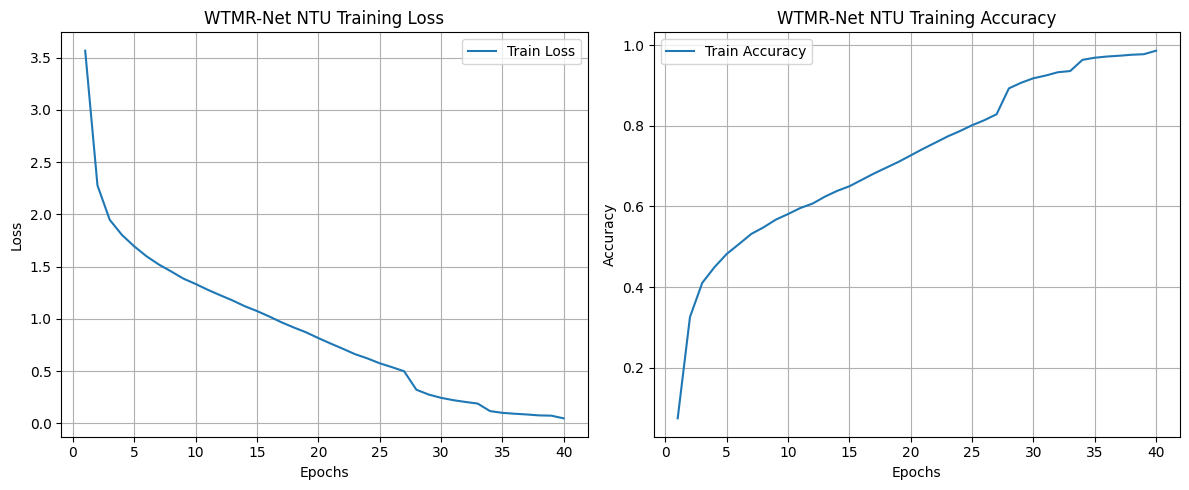

In [16]:
import matplotlib.pyplot as plt

epochs = historyn["epochs3"]
train_loss = historyn["train_loss3"]
val_loss = historyn["val_loss3"]
train_acc = historyn["train_acc3"]
val_acc = historyn["val_acc3"]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WTMR-Net NTU Training Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Accuracy", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("WTMR-Net NTU Training Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
